In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 11.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
import cv2
from PIL import Image
from ultralytics import YOLO

import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from catboost import CatBoostClassifier

In [ ]:
cig = r'/content/drive/MyDrive/Something/best.pt'
points = r'yolov8n-pose.pt'
people = r'yolov8n.pt'
CB = r'/content/drive/MyDrive/Something/pointciglast.cbm'
test_img_path = '/content/111.jpg'

In [ ]:
model_cig = YOLO(cig)
net = YOLO(people)
net.classes = [0]
model = CatBoostClassifier(iterations=250, depth=12, learning_rate=0.1,
                           loss_function='Logloss', custom_metric=['AUC'], random_seed=42)
model.load_model(CB)
model_points = YOLO(points)

In [ ]:
def get_predict(model_cig=model_cig,face=net,image_file='/content/111.jpg',threshold=0.3):
  image = cv2.imread(image_file)
  face = model_points(image,verbose=False)[0]
  face_list = []
  for k in range(len(face.boxes.xyxy)):
      if int(face.boxes.cls[k])==0:
        (startX,startY,endX,endY) = (np.array(face.boxes.xyxy)[k]).astype("int")
        face_list.append((startX,startY,endX,endY,k))
  for j in face_list:
    x,y,w,h,k = j
    image1 = image[y:h,x:w]
    res = model_cig(image1,verbose=False)
    if len(res[0].boxes.xyxy)>0 and max(res[0].boxes.conf)>threshold:
      return 1
  return 0

In [ ]:
def predict(model=model,model_points=model_points,img_path='/content/111.jpg'):
  results = model_points(img_path)
  result_keypoint = results[0].keypoints.xyn.cpu().numpy()[0].flatten()
  if len(result_keypoint)!=0:
    pred = model.predict(result_keypoint)
    return pred
  return 0

In [ ]:
!unzip /content/drive/MyDrive/Something/smokers_not.zip

In [ ]:
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
smok = [f for f in listdir('/content/train/smoking')]
notsmok =[f for f in listdir('/content/train/notsmoking')]

In [ ]:
from random import shuffle
smokval = [f for f in listdir('/content/valid/smoking')]
notsmokval =[f for f in listdir('/content/valid/notsmoking')]
testX = smokval+notsmokval
testy = [1]*len(smokval)+[0]*len(notsmokval)
data = list(zip(testX,testy))
shuffle(data)

In [ ]:
tp = 0
fp = 0
fn = 0
tn = 0
for x,y in data[:100]:
  out = 0
  if y==0:
    out = get_predict(model_cig,net,f'/content/valid/notsmoking/{x}',0.3)
  else:
    out = get_predict(model_cig,net,f'/content/valid/smoking/{x}',0.3)
  out = int(out)
  if y==0 and out==0:
    tn+=1
  elif y==1 and out==1:
    tp+=1
  elif y==1 and out==0:
    fn+=1
  else:
    fp+=1
print('accuracy:',(tp+tn)/(tp+tn+fp+fn))
print('precision:',tp/(tp+fp))
print('recall:',tp/(tp+fn))

accuracy: 0.81
precision: 0.875
recall: 0.6511627906976745


In [ ]:
tp = 0
fp = 0
fn = 0
tn = 0
for x,y in data[:100]:
  out = 0
  if y==0:
    out = predict(model,model_points,f'/content/valid/notsmoking/{x}')
  else:
    out = predict(model,model_points,f'/content/valid/smoking/{x}')
  out = int(out)
  if y==0 and out==0:
    tn+=1
  elif y==1 and out==1:
    tp+=1
  elif y==1 and out==0:
    fn+=1
  else:
    fp+=1
print('accuracy:',(tp+tn)/(tp+tn+fp+fn))
print('precision:',tp/(tp+fp))
print('recall:',tp/(tp+fn))

accuracy: 0.69
precision: 0.62
recall: 0.7209302325581395


In [ ]:
d = 0.1
tp = 0
fp = 0
fn = 0
tn = 0
for x,y in data[:100]:
  out1 = 0
  out2 = 0
  if y==0:
    out1 = predict(model,model_points,f'/content/valid/notsmoking/{x}')
    out2= get_predict(model_cig,net,f'/content/valid/notsmoking/{x}',0.3)
  else:
    out1 = predict(model,model_points,f'/content/valid/smoking/{x}')
    out2 = get_predict(model_cig,net,f'/content/valid/smoking/{x}',0.3)
  out1 = int(out1)
  out2 = int(out2)
  out = out1 or out2
  if y==0 and out==0:
    tn+=1
  elif y==1 and out==1:
    tp+=1
  elif y==1 and out==0:
    fn+=1
  else:
    fp+=1
print('accuracy:',(tp+tn)/(tp+tn+fp+fn))
print('precision:',tp/(tp+fp))
print('recall:',tp/(tp+fn))

accuracy: 0.76
precision: 0.6507936507936508
recall: 0.9534883720930233


In [ ]:
import numpy as np
import torch
smokers_np  = []
smokers = [] # люди, выделенные 1 моделью, как курящие
not_smokers = [] # люди, не выделенные 1 моделью, как курящие
for i in smokers:
  if len(i)>0:
    smokers_np.append(list(np.array(i)))
notsmokers_np = []
for i in not_smokers:
  if len(i)>0:
    notsmokers_np.append(list(np.array(i)))
smokers_ts = torch.tensor(np.stack(smokers_np))
notsmokers_ts = torch.tensor(np.stack(notsmokers_np))
print(smokers_ts.size())
print(notsmokers_ts.size())

torch.Size([1085, 34])
torch.Size([2210, 34])


In [ ]:
datX = torch.cat((smokers_ts,notsmokers_ts[:1085]),axis=0)
datY = torch.cat((torch.tensor([1]*1085),torch.tensor([0]*(1085))),axis=0).unsqueeze_(1)
print(datY)

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])


In [ ]:
!pip install catboost

In [ ]:
from sklearn.model_selection import train_test_split
Xnp = np.array(datX)
Ynp = np.array(datY)
X_train, X_test, y_train, y_test = train_test_split(Xnp, Ynp, test_size=0.1, random_state=42)

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=250, depth=12, learning_rate=0.1,
                           loss_function='Logloss', custom_metric=['AUC'], random_seed=42)
model.fit(X_train,y_train)

0:	learn: 0.6699037	total: 546ms	remaining: 2m 15s
1:	learn: 0.6498140	total: 1.14s	remaining: 2m 20s
2:	learn: 0.6257663	total: 1.66s	remaining: 2m 16s
3:	learn: 0.6024573	total: 2.19s	remaining: 2m 14s
4:	learn: 0.5853959	total: 2.5s	remaining: 2m 2s
5:	learn: 0.5749861	total: 2.82s	remaining: 1m 54s
6:	learn: 0.5633100	total: 3.13s	remaining: 1m 48s
7:	learn: 0.5456147	total: 3.44s	remaining: 1m 43s
8:	learn: 0.5400655	total: 3.75s	remaining: 1m 40s
9:	learn: 0.5293218	total: 4.07s	remaining: 1m 37s
10:	learn: 0.5220184	total: 4.38s	remaining: 1m 35s
11:	learn: 0.5113756	total: 4.68s	remaining: 1m 32s
12:	learn: 0.4998546	total: 5.01s	remaining: 1m 31s
13:	learn: 0.4928100	total: 5.32s	remaining: 1m 29s
14:	learn: 0.4852438	total: 5.63s	remaining: 1m 28s
15:	learn: 0.4754772	total: 5.96s	remaining: 1m 27s
16:	learn: 0.4681279	total: 6.27s	remaining: 1m 25s
17:	learn: 0.4576878	total: 6.58s	remaining: 1m 24s
18:	learn: 0.4532627	total: 6.88s	remaining: 1m 23s
19:	learn: 0.4449331	tot

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=100, depth=12, learning_rate=0.1,
                           loss_function='Logloss', custom_metric=['AUC'], random_seed=42)
model.load_model('/content/drive/MyDrive/Something/pointcig1.cbm')

In [ ]:
print((model.predict(X_test).reshape(-1,1)==y_test).sum()/len(X_test))

0.6682027649769585


In [ ]:
model.save_model('pointciglast.cbm','cbm')

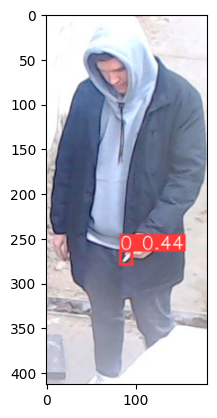

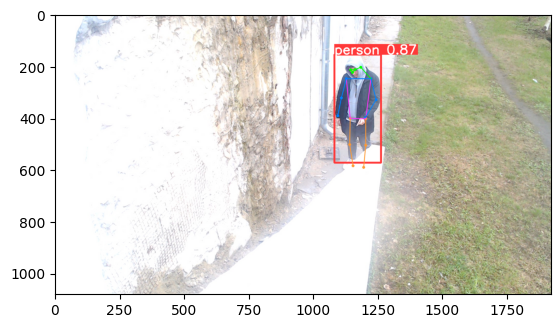

In [ ]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
img = [f for f in listdir('/content/drive/MyDrive/Something/dataset')]
img_path = f'/content/drive/MyDrive/Something/dataset/{img[13]}'
def inference(img_path=img_path):
  image = cv2.imread(img_path)
  face = net(image,verbose=False)[0]
  face_list = []
  for k in range(len(face.boxes.xyxy)):
    if int(face.boxes.cls[k])==0:
      (startX,startY,endX,endY) = (np.array(face.boxes.xyxy)[k]).astype("int")
      face_list.append((startX,startY,endX,endY))
  for j in face_list:
    x,y,w,h = j
    image1 = image[y:h,x:w]
    res = model_cig(image1)
    if len(res[0].boxes.xyxy)>=0:
      res_plotted = res[0].plot()
      imageRGB = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
      image2 = Image.fromarray(imageRGB)
      imgplot = plt.imshow(image2)
      plt.show()
  imm = cv2.imread(img_path)
  res = model_points(imm)
  res_plotted = res[0].plot()
  imageRGB1 = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
  image1 = Image.fromarray(imageRGB1)
  imgplot = plt.imshow(image1)
  plt.show()
inference()

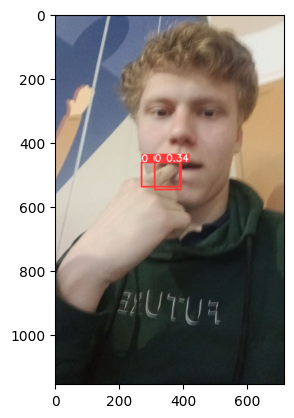

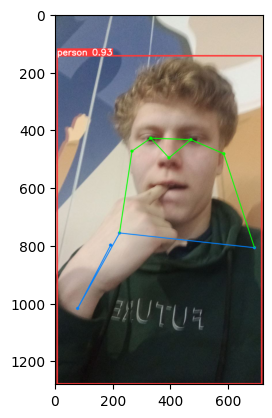

In [40]:
inference('/content/5.jpg')